In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import heapq
import re
import concurrent.futures
from tqdm import tqdm

In [2]:
filterFilePath = '../data/filterFile.csv'
df = pd.read_csv(filterFilePath)

In [3]:
def getKeyNum(df):
    # 提取 results 列中带有 "#" 号的字段
    pattern = r'#\w+'  
    results = df['results'].str.cat(sep=' ')  # 将所有 results 列的数据合并为一个字符串
    hashtags = set(re.findall(pattern, results))  # 使用正则表达式提取带 "#" 号的字段，并去重

    # 统计每个带 "#" 号的字段在整个文件中出现的次数
    hashtags_dict = {}
    for hashtag in hashtags:
        count = results.count(hashtag)
        hashtags_dict[hashtag] = count
    return hashtags_dict

def showKeyNum(hashtags_dict):
    # 将字典按值从大到小排序
    hashtags_dict_sorted = sorted(hashtags_dict.items(), key=lambda x: x[1], reverse=True)

    # 提取排序后的键和值
    hashtags_sorted = [item[0] for item in hashtags_dict_sorted]
    counts_sorted = [item[1] for item in hashtags_dict_sorted]

    # 绘制柱状图
    plt.figure(figsize=(180, 25))  
    plt.bar(hashtags_sorted, counts_sorted)  
    plt.xticks(rotation=90)  
    plt.xlabel('Hashtags')  
    plt.ylabel('Counts')  
    plt.title('Hashtags Counts')  
    plt.show()

def getTop10Key(hashtags_dict):
    # 获取字典中数量前十的字段
    top_n = 10  # 自定义获取前几个字段
    top_n_fields = heapq.nlargest(top_n, hashtags_dict, key=hashtags_dict.get)
    
    print("数量前十的字段：")
    for field in top_n_fields:
        print("字段名: {:<30s} 出现次数: {:d}".format(field, hashtags_dict[field]))

In [4]:
hashtags_dict=getKeyNum(df)

In [5]:
def get_input_output(Tdf, field):
    df = Tdf.copy()
    input_list = []
    output_list = []
    for i in range(len(df)):
        row = df.iloc[i]
        if field in row['results']:
            result_dict = json.loads(row['results'])
            if field in result_dict:
                dimension_dict = json.loads(row['dimension'])
                input_list.append([
                    float(dimension_dict['cvm_cpu']) if 'cvm_cpu' in dimension_dict else -1,
                    float(dimension_dict['cvm_memory'].split()[0]) if 'cvm_memory' in dimension_dict else -1,
                    dimension_dict.get('cvm_cpu_qos', 'false') == 'true',
                    dimension_dict.get('cvm_os_type', ''),
                    row['results_key']
                ])
                output_list.append(result_dict[field])
    input_df = pd.DataFrame(input_list, columns=['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type', 'results_key'])
    output_df = pd.DataFrame({field: output_list})
    return input_df, output_df


def get_input_output_Speed(Tdf, field):
    # 选择需要提取的字段
    df = Tdf.copy()
    keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']

    # 对dimension列进行预处理
    df['dimension'] = df['dimension'].apply(lambda x: json.loads(x))
    for key in keys_to_extract:
        df[key] = df['dimension'].apply(lambda x: x.get(key, None))

    # 对cvm_memory和cvm_cpu进行数值化处理
    df[['cvm_cpu', 'cvm_memory']] = df[['cvm_cpu', 'cvm_memory']].apply(pd.to_numeric, errors='coerce').fillna(-1)

    # 筛选出符合要求的行
    df_filtered = df[df['results'].str.contains(field)]

    # 从results中提取出field对应的值
    df_output = pd.DataFrame(df_filtered['results'].apply(lambda x: json.loads(x)).tolist(), index=df_filtered.index)
    df_output = df_output[field]

    # 将input和output分别转成dataframe
    df_input = df_filtered[keys_to_extract + ['results_key']]
    df_output = pd.DataFrame(df_output)

    return df_input, df_output

In [6]:
your_field = '#unixbench_cpu'
# inPutDF, outPutDF = get_input_output(df, your_field)
inPutDF, outPutDF = get_input_output_Speed(df, your_field)

In [7]:
print(inPutDF.shape)
print(outPutDF.shape)

(23444, 5)
(23444, 1)


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
import pickle
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve

In [9]:
def showPic(methodName, y_test, y_pred):
    # 创建柱状图
    plt.figure(figsize=(80, 15))

    plt.subplot(1, 2, 1)
    # 创建样本索引数组
    index = np.arange(len(y_test))
    # 绘制线性回归模型的折线图
    plt.plot(index, y_test, label='True Values')
    plt.plot(index, y_pred, label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.title('{}: True Values vs. Predicted Values'.format(methodName))
    plt.legend()
    plt.show()


def showCoef(linear_reg, decision_tree_reg, random_forest_reg):
    # 绘制特征重要性条形图
    if len(linear_reg.coef_) > 1:
        coef_abs = np.abs(linear_reg.coef_)
        sorted_idx = np.argsort(coef_abs)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(coef_abs)), coef_abs[sorted_idx])
        plt.xticks(range(len(coef_abs)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance (by coefficient absolute value)')
        plt.title('Linear Regression - Feature Importance')
        plt.show()
    else:
        print('Linear Regression - No feature importance to plot')

    if len(decision_tree_reg.feature_importances_) > 1:
        feature_importances = decision_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
        plt.xticks(range(len(feature_importances)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Decision Tree - Feature Importance')
        plt.show()
    else:
        print('Decision Tree - No feature importance to plot')

    if len(random_forest_reg.feature_importances_) > 1:
        feature_importances = random_forest_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        plt.figure(figsize=(150, 20))
        plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
        plt.xticks(range(len(feature_importances)), sorted_idx)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Importance')
        plt.title('Random Forest - Feature Importance')
        plt.show()
    else:
        print('Random Forest - No feature importance to plot')


def getCoef(linear_reg, decison_tree_reg, random_forest_reg):
    result = []
    if len(linear_reg.coef_) > 1:
        coef_abs = np.abs(linear_reg.coef_)
        sorted_idx = np.argsort(coef_abs)
        # 将最后10个特征的索引存入templist中
        templist = []
        for i in range(1, 11):
            templist.append(sorted_idx[-i])
        result.append(templist)
    else:
        result.append([])
    if len(decison_tree_reg.feature_importances_) > 1:
        feature_importances = decison_tree_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        # 将最后10个特征的索引存入templist中
        templist = []
        for i in range(1, 11):
            templist.append(sorted_idx[-i])
        result.append(templist)
    else:
        result.append([])
    if len(random_forest_reg.feature_importances_) > 1:
        feature_importances = random_forest_reg.feature_importances_
        sorted_idx = np.argsort(feature_importances)
        # 将最后10个特征的索引存入templist中
        templist = []
        for i in range(1, 11):
            templist.append(sorted_idx[-i])
        result.append(templist)
    else:
        result.append([])
    return result


def getFeatureName(result, inputDF):
    feature_names = inputDF.columns
    linear_reg_indices = result[0]  # 线性回归模型的特征索引
    decision_tree_indices = result[1]  # 决策树模型的特征索引
    random_forest_indices = result[2]  # 随机森林模型的特征索引

    linear_reg_feature_names = feature_names[linear_reg_indices].tolist()  # 线性回归模型的特征列名列表
    decision_tree_feature_names = feature_names[decision_tree_indices].tolist()  # 决策树模型的特征列名列表
    random_forest_feature_names = feature_names[random_forest_indices].tolist()  # 随机森林模型的特征列名列表
    
    linear_reg_features = inputDF[linear_reg_feature_names]  # 线性回归模型的特征值
    decision_tree_features = inputDF[decision_tree_feature_names]  # 决策树模型的特征值
    random_forest_features = inputDF[random_forest_feature_names]  # 随机森林模型的特征值


def showDecisonTree(decision_tree_reg, flag=False):
    if flag:    
        plt.figure(figsize=(20, 10))  # 设置画布大小
        plot_tree(decision_tree_reg, max_depth=2, feature_names=None, filled=True, rounded=True)  # 设置最大深度为2，可以根据需要调整
        plt.title('Decision Tree')
        plt.show()


def showRandomForest(random_forest_reg, flag=False):
    if flag:
        if len(random_forest_reg.feature_importances_) > 1:
            # 获取特征重要性
            feature_importances = random_forest_reg.feature_importances_
            # 选择特征重要性最高的决策树
            best_tree_index = np.argmax(feature_importances)
            if best_tree_index >= random_forest_reg.n_estimators:
                best_tree_index = random_forest_reg.n_estimators - 1

            plt.figure(figsize=(20, 10))
            plot_tree(random_forest_reg.estimators_[best_tree_index], max_depth=2, feature_names=None, filled=True, rounded=True)
            plt.title('Best Decision Tree')
            plt.show()
        else:
            print('Random Forest - No feature importance to plot')


def getModel(X_train, y_train, save_path):
    # 初始化模型
    linear_reg = LinearRegression()
    decision_tree_reg = DecisionTreeRegressor()
    random_forest_reg = RandomForestRegressor(n_estimators=100, max_depth=5)
    svm_reg = SVR(C=1.0, epsilon=0.1)
    knn_reg = KNeighborsRegressor(n_neighbors=10, weights='uniform')

    # 拟合模型
    linear_reg.fit(X_train, y_train)
    decision_tree_reg.fit(X_train, y_train)
    random_forest_reg.fit(X_train, y_train)
    svm_reg.fit(X_train, y_train)
    knn_reg.fit(X_train, y_train)

    # 保存模型
    models = {
        'linear_reg': linear_reg,
        'decision_tree_reg': decision_tree_reg,
        'random_forest_reg': random_forest_reg,
        'svm_reg': svm_reg,
        'knn_reg': knn_reg
    }
    # save_path = 'model/'
    for model_name, model in models.items():
        with open(save_path + model_name + '.pkl', 'wb') as f:
            pickle.dump(model, f)

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg


def train(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = getModel(X_train, y_train, save_path)

    # 预测
    y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_random_forest_reg = random_forest_reg.predict(X_test)
    y_pred_svm_reg = svm_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)

    # 计算评估指标
    r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_random_forest_reg = r2_score(y_test, y_pred_random_forest_reg)
    r2_svm_reg = r2_score(y_test, y_pred_svm_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression R2:', '{:.8f}'.format(r2_linear_reg)))
    print('{:<30} {:>10}'.format('Decision Tree R2:', '{:.8f}'.format(r2_decision_tree_reg)))
    print('{:<30} {:>10}'.format('Random Forest R2:', '{:.8f}'.format(r2_random_forest_reg)))
    print('{:<30} {:>10}'.format('SVM R2:', '{:.8f}'.format(r2_svm_reg)))
    print('{:<30} {:>10}'.format('KNN R2:', '{:.8f}'.format(r2_knn_reg)))
    print('\n')

    models = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'SVM Regression', 'KNN Regression']
    y_pred = ['y_pred_linear_reg', 'y_pred_decision_tree_reg', 'y_pred_random_forest_reg', 'y_pred_svm_reg', 'y_pred_knn_reg']
    for i in range(len(models)):
        showPic(models[i], y_test, eval(y_pred[i]))

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg


def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


def judgeResult(model, X_train, y_train, X_test, y_test):
    # 在训练集和测试集上计算评估指标
    y_train = y_train.values
    y_test = y_test.values
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    print('Model: {}'.format(model.__class__.__name__))
    print('{:<30} {:>10}'.format('Train R2:', '{:.8f}'.format(r2_train)))
    print('{:<30} {:>10}'.format('Test R2:', '{:.8f}'.format(r2_test)))
    
    # 绘制学习曲线
    # plot_learning_curve(model, X_train, y_train)

    # 判断过拟合
    if r2_test >= r2_train:
        print("模型可能存在过拟合的问题\n\n")
    else:
        print("模型可能没有过拟合的问题\n\n")


def trainOverFit(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = getModel(X_train, y_train, save_path)

    # 预测

    y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_random_forest_reg = random_forest_reg.predict(X_test)
    y_pred_svm_reg = svm_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)

    # 计算评估指标
    r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_random_forest_reg = r2_score(y_test, y_pred_random_forest_reg)
    r2_svm_reg = r2_score(y_test, y_pred_svm_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression R2:', '{:.8f}'.format(r2_linear_reg)))
    print('{:<30} {:>10}'.format('Decision Tree R2:', '{:.8f}'.format(r2_decision_tree_reg)))
    print('{:<30} {:>10}'.format('Random Forest R2:', '{:.8f}'.format(r2_random_forest_reg)))
    print('{:<30} {:>10}'.format('SVM R2:', '{:.8f}'.format(r2_svm_reg)))
    print('{:<30} {:>10}'.format('KNN R2:', '{:.8f}'.format(r2_knn_reg)))
    print('\n')

    models = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'SVM Regression', 'KNN Regression']
    y_pred = [y_pred_linear_reg, y_pred_decision_tree_reg, y_pred_random_forest_reg, y_pred_svm_reg, y_pred_knn_reg]
    # for i in range(len(models)):
    #     showPic(models[i], y_test, y_pred[i])

    getModelList = ['linear_reg', 'decision_tree_reg', 'random_forest_reg', 'svm_reg', 'knn_reg']

    for i in range(len(models)):
        judgeResult(eval(getModelList[i]), X_train, y_train, X_test, y_test)

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg


def getFeatureName(X, result):
    feature_names = X.columns
    linear_reg_indices = result[0]  # 线性回归模型的特征索引
    decision_tree_indices = result[1]  # 决策树模型的特征索引
    random_forest_indices = result[2]  # 随机森林模型的特征索引
    resDict={}
    if len(linear_reg_indices) > 0:
        print('linear_reg_index: ', linear_reg_indices)
        linear_reg_feature_names = feature_names[linear_reg_indices].tolist()
        print('linear_reg_feature_names: ', linear_reg_feature_names)
        resDict['linear_reg_feature_names']=linear_reg_feature_names
    if len(decision_tree_indices) > 0:
        print('decision_tree_reg_index: ', decision_tree_indices)
        decision_tree_feature_names = feature_names[decision_tree_indices].tolist()
        print('decision_tree_feature_names: ', decision_tree_feature_names)
        resDict['decision_tree_feature_names']=decision_tree_feature_names
    if len(random_forest_indices) > 0:
        print('random_forest_reg_index: ', random_forest_indices)
        random_forest_feature_names = feature_names[random_forest_indices].tolist()
        print('random_forest_feature_names: ', random_forest_feature_names)
        resDict['random_forest_feature_names']=random_forest_feature_names
    return resDict


In [10]:
inPutDF['cvm_cpu'] = pd.to_numeric(inPutDF['cvm_cpu'])
inPutDF['cvm_memory'] = pd.to_numeric(inPutDF['cvm_memory'])
one_hot_df = pd.get_dummies(inPutDF, columns=['cvm_cpu_qos', 'cvm_os_type','results_key'])
X = one_hot_df
y = outPutDF
print(X.shape)
print(y.shape)

(23444, 198)
(23444, 1)


e:\test\envs\pytorch\lib\site-packages\ipykernel_launcher.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
e:\test\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Linear Regression R2:          0.96728523
Decision Tree R2:              0.97947662
Random Forest R2:              0.44157525
SVM R2:                        -0.23156895
KNN R2:                        0.86915455




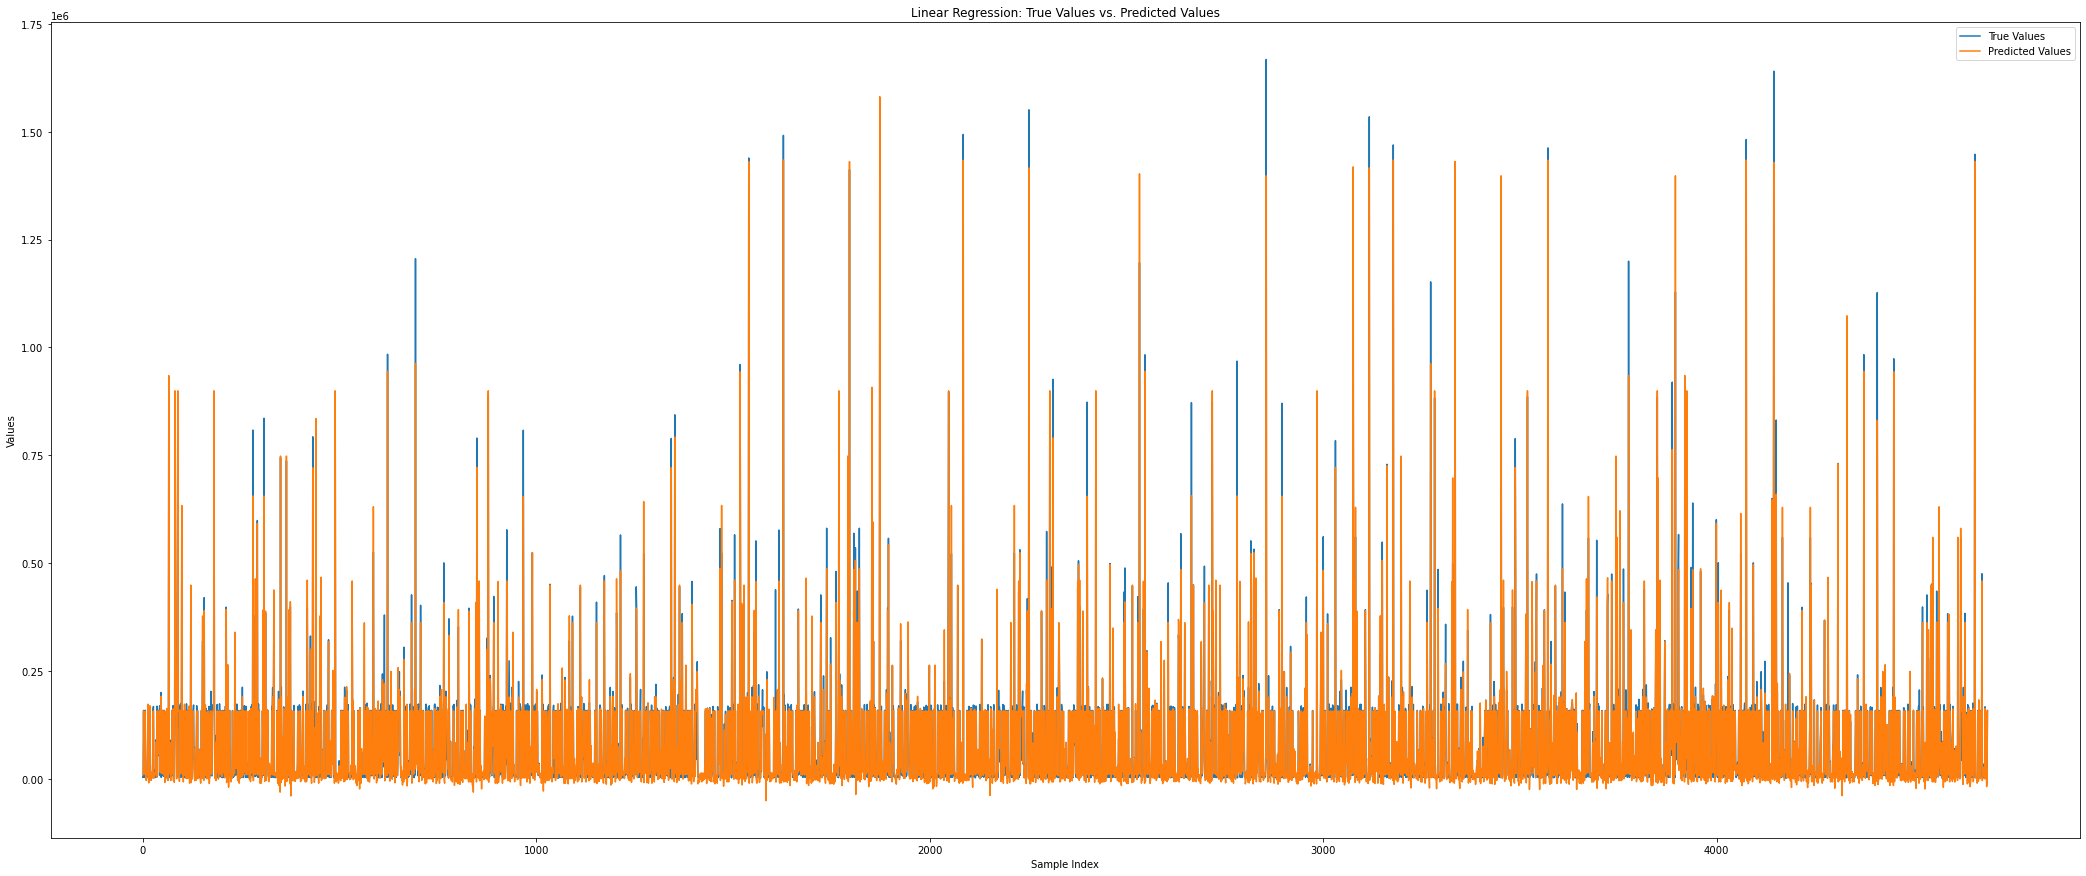

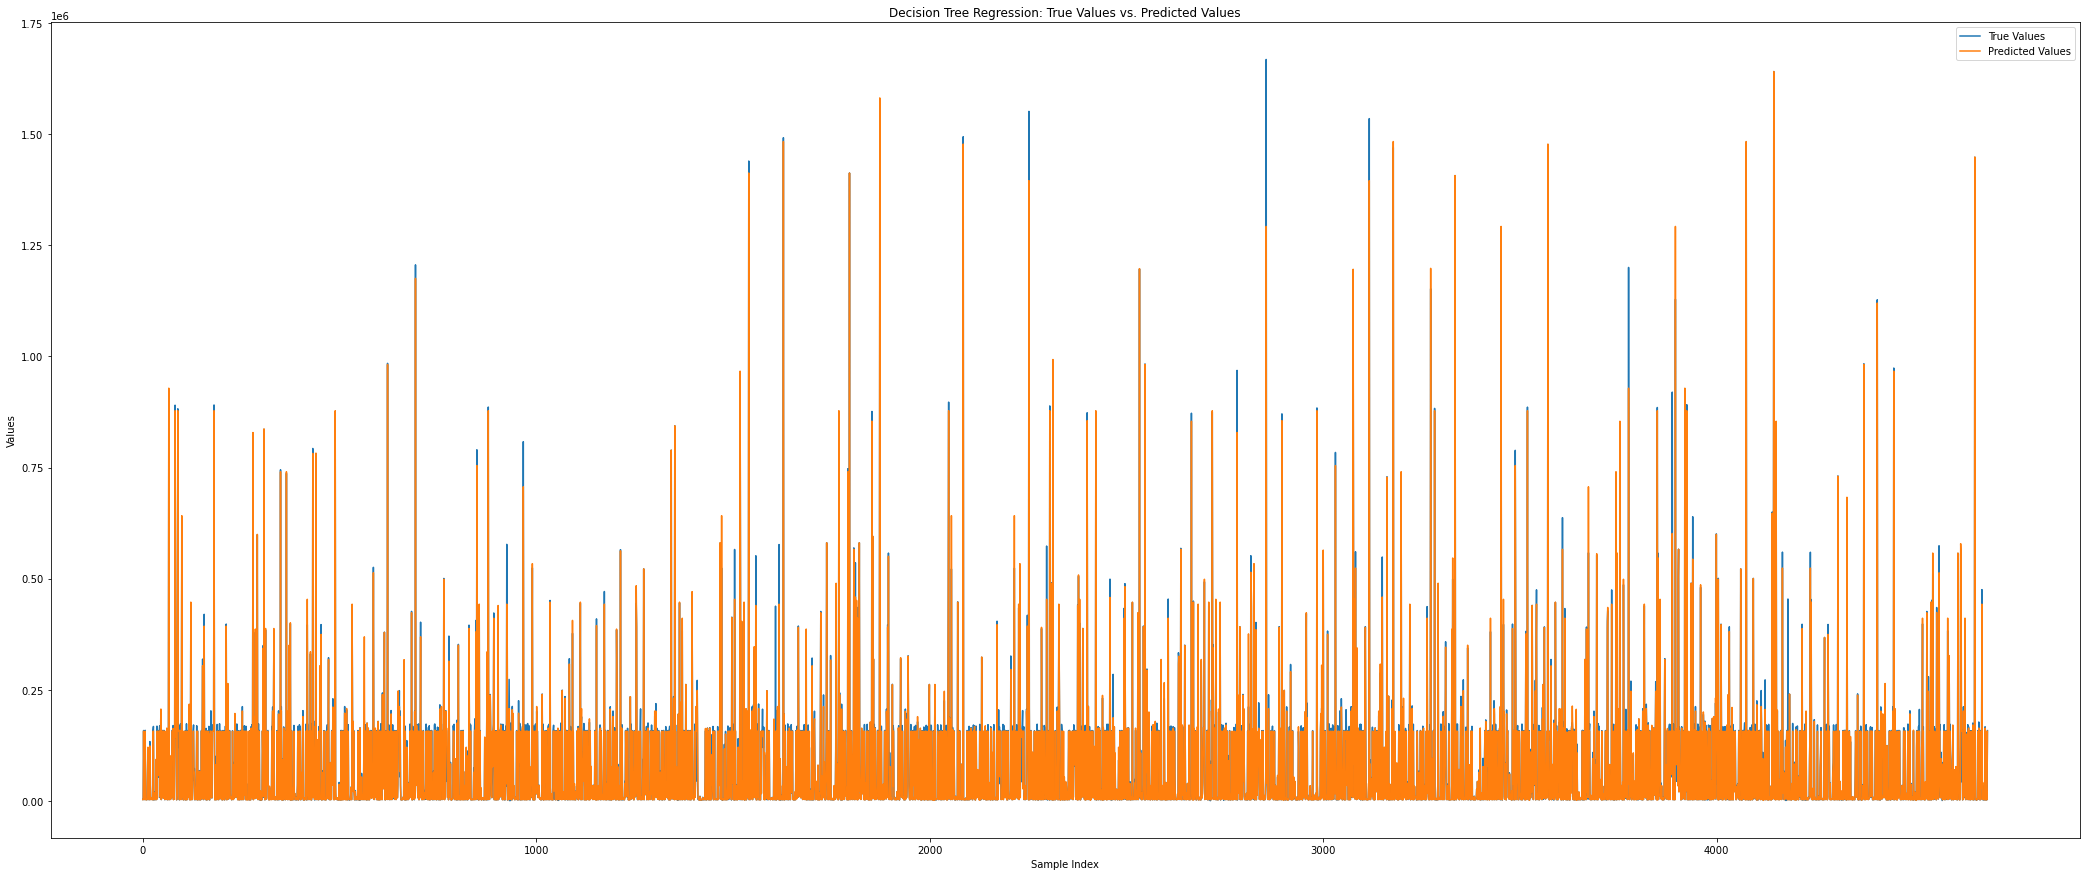

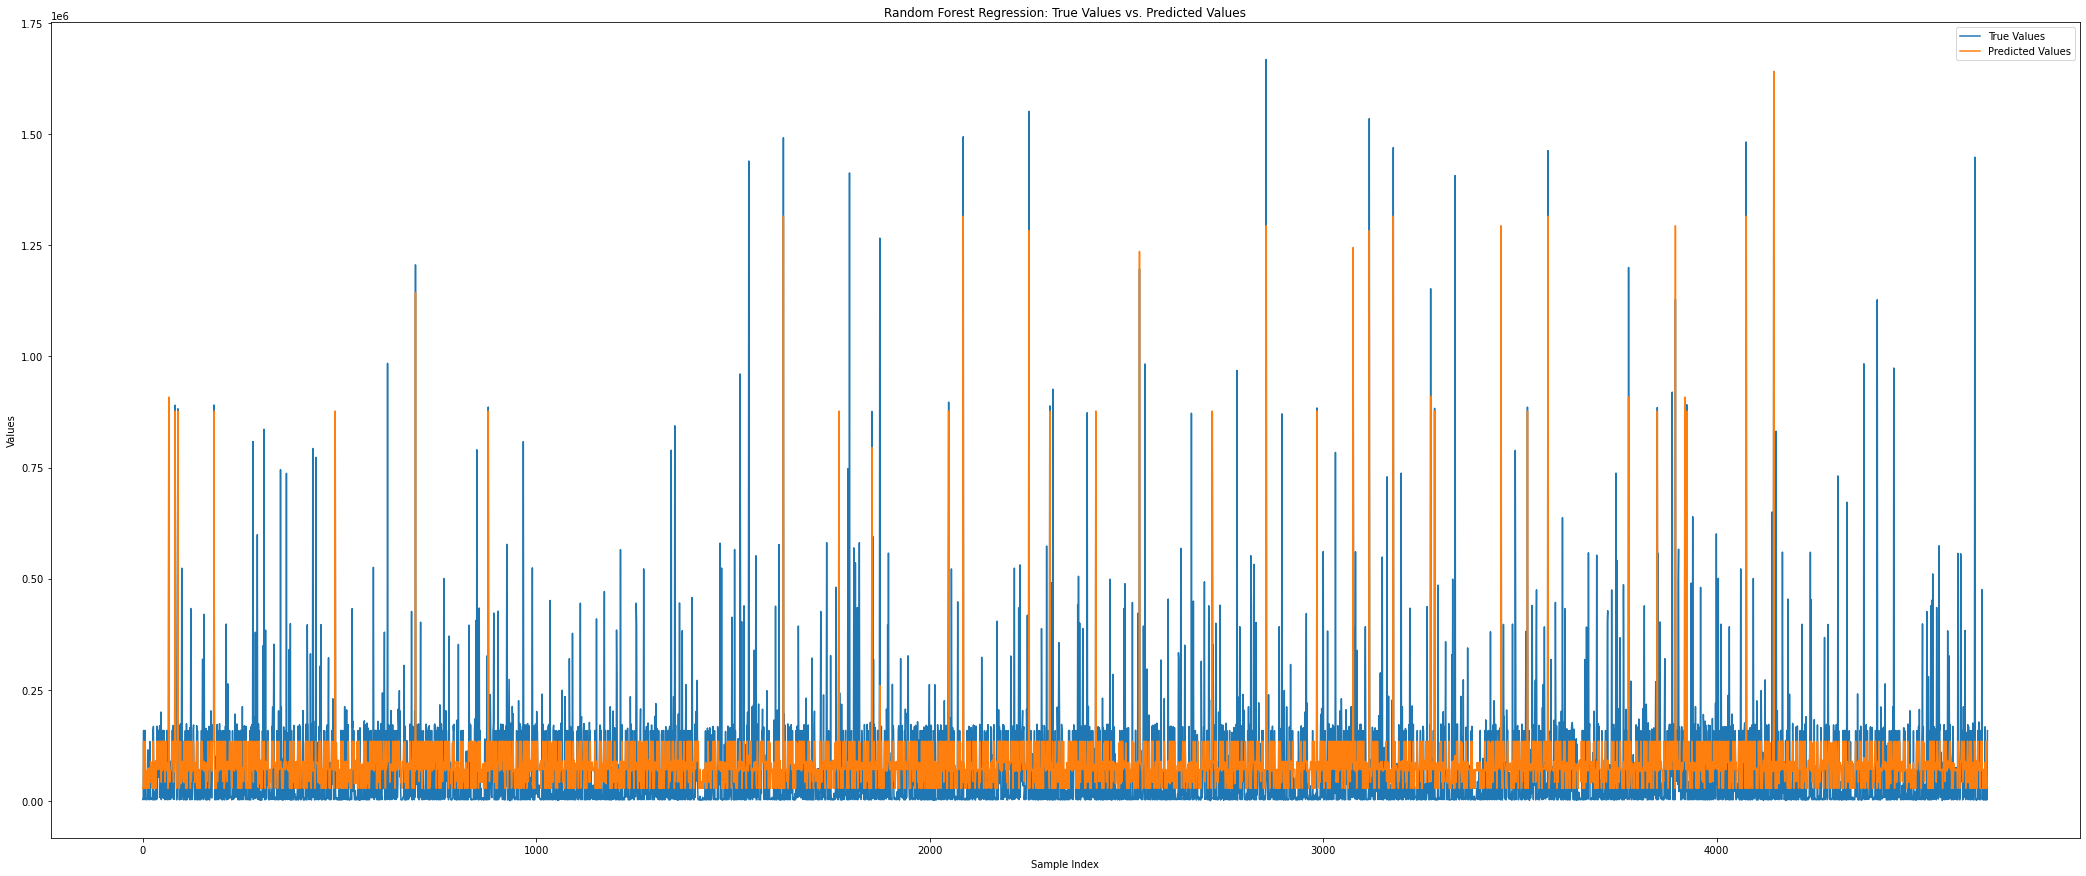

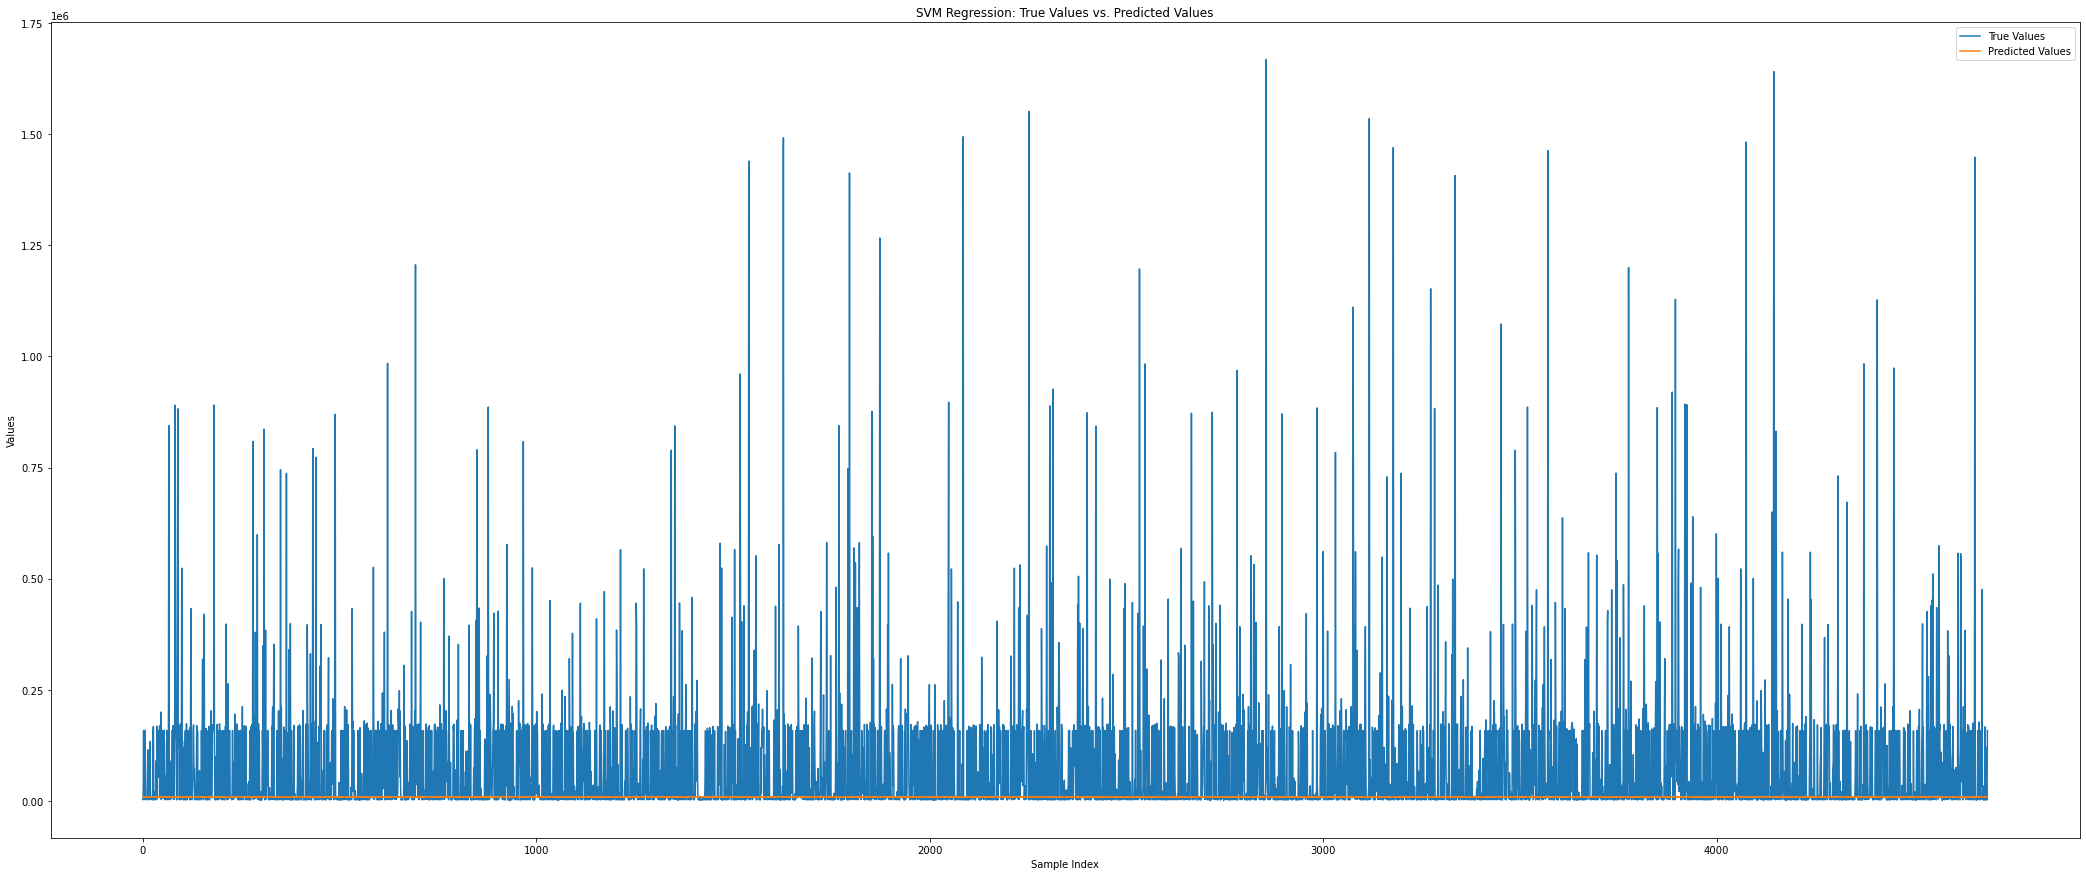

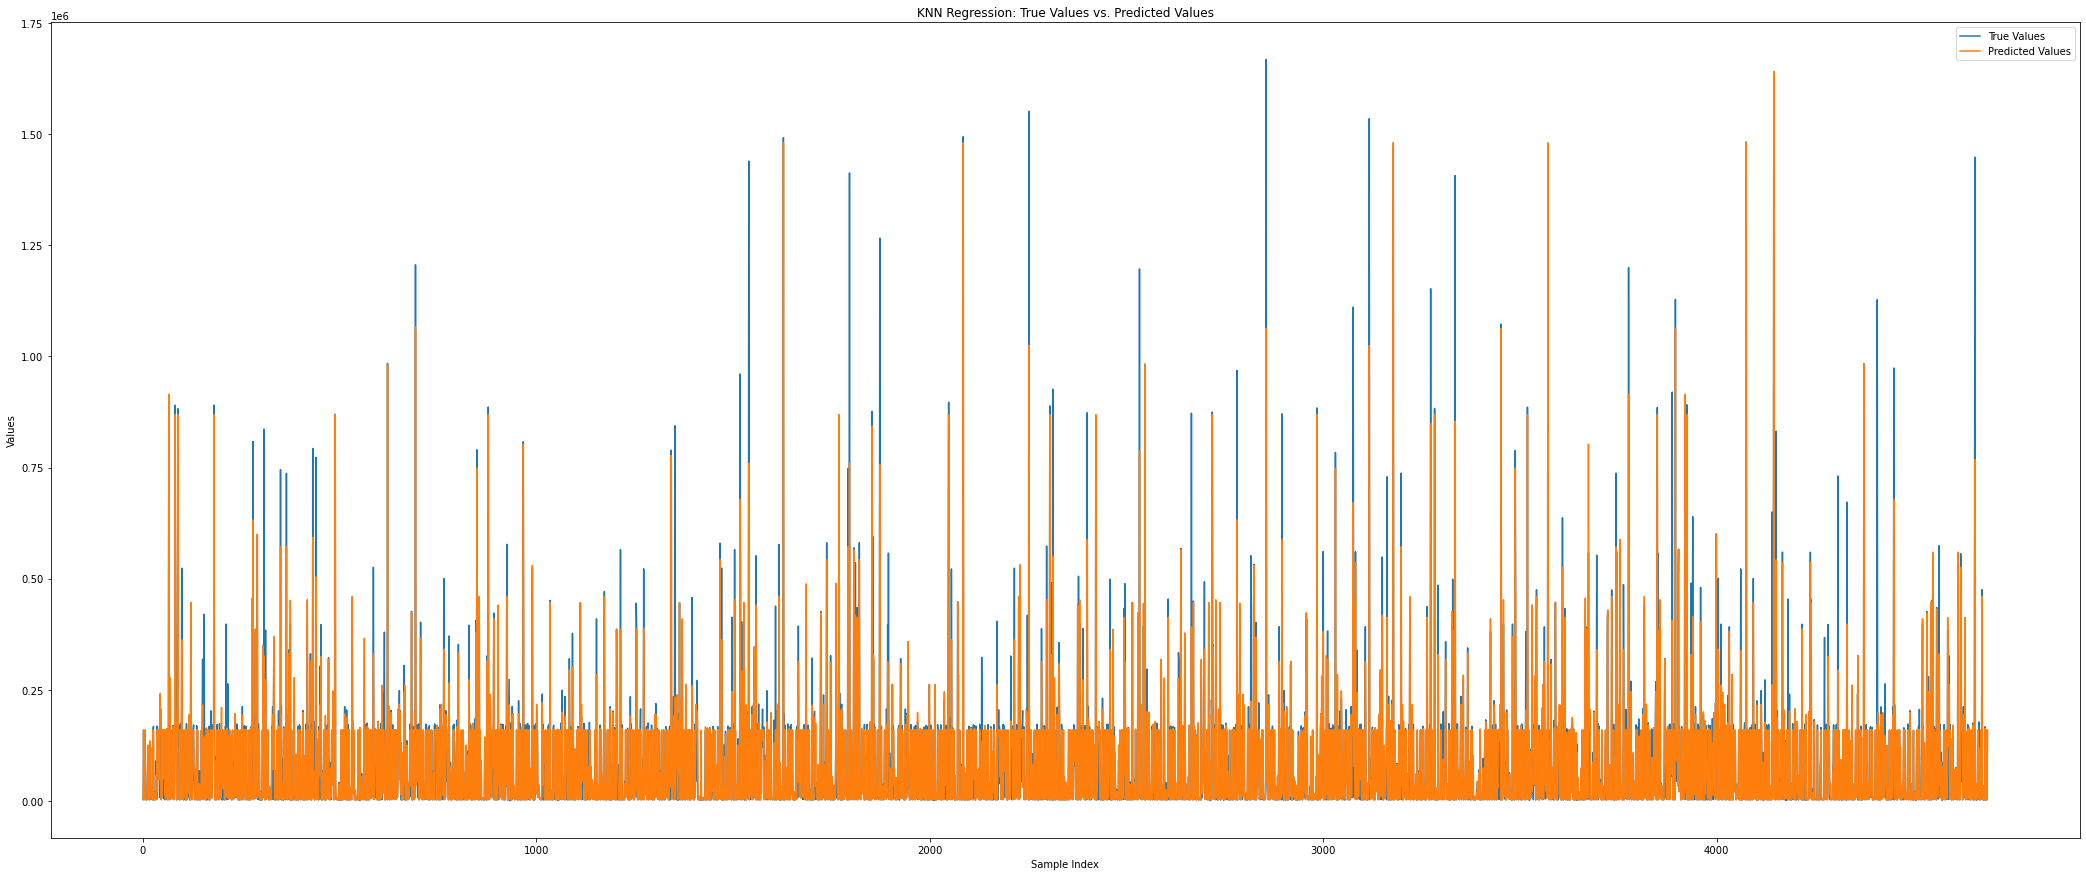

In [11]:
save_path = 'model/{}'.format(your_field)
# 判断是否有这个文件夹，没有就创建 
if not os.path.exists(save_path):
    os.makedirs(save_path)

# linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = trainOverFit(X, y, save_path)

linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = train(X, y, save_path)

In [12]:
linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = trainOverFit(X, y, save_path)

e:\test\envs\pytorch\lib\site-packages\ipykernel_launcher.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
e:\test\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Linear Regression R2:          0.96728523
Decision Tree R2:              0.98154563
Random Forest R2:              0.43399325
SVM R2:                        -0.23156895
KNN R2:                        0.86915455


Model: LinearRegression
Train R2:                      0.95493227
Test R2:                       0.96728523
模型可能存在过拟合的问题


Model: DecisionTreeRegressor
Train R2:                      0.97523125
Test R2:                       0.98154563
模型可能存在过拟合的问题


Model: RandomForestRegressor
Train R2:                      0.49774939
Test R2:                       0.43399325
模型可能没有过拟合的问题


Model: SVR
Train R2:                      -0.23097874
Test R2:                       -0.23156895
模型可能没有过拟合的问题


Model: KNeighborsRegressor
Train R2:                      0.88106643
Test R2:                       0.86915455
模型可能没有过拟合的问题




In [13]:
flag=True

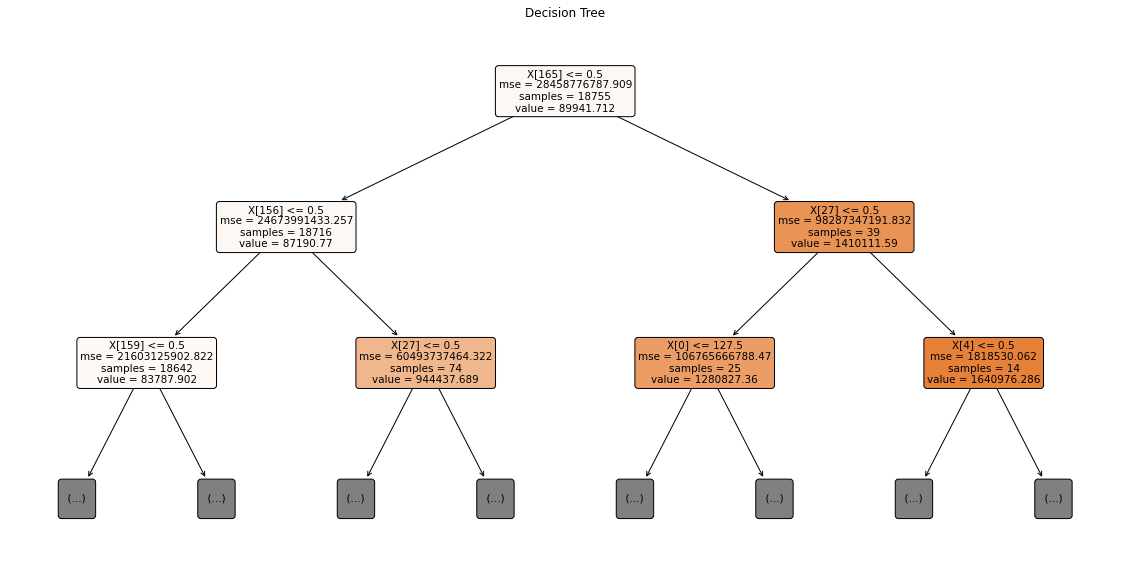

In [14]:
# 打印决策树
showDecisonTree(decision_tree_reg, flag)

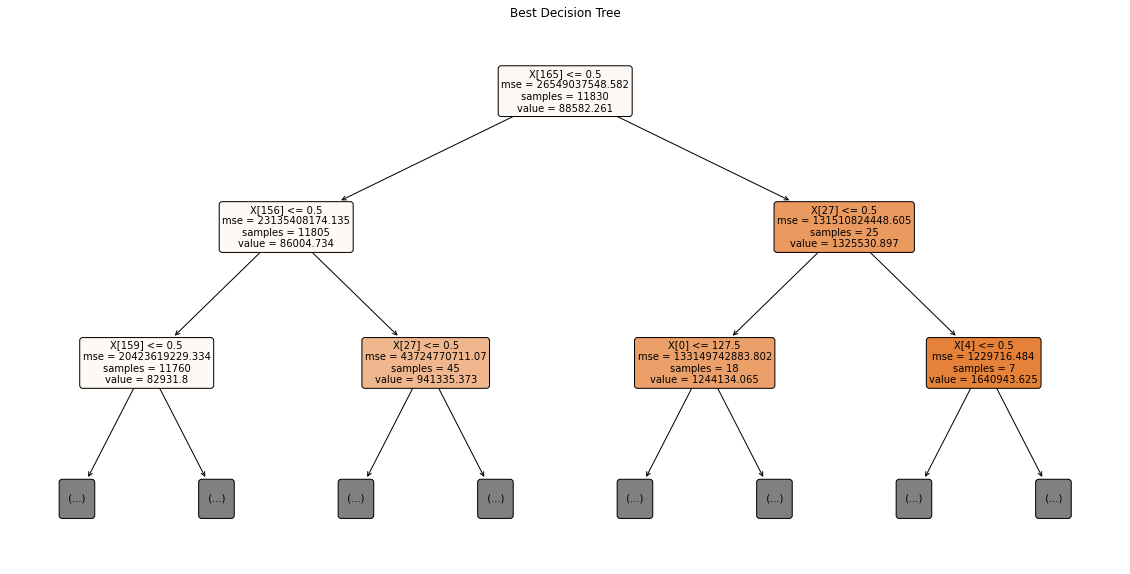

In [15]:
# 打印随机森林
showRandomForest(random_forest_reg, flag)

In [16]:
resultCoef = getCoef(linear_reg, decision_tree_reg, random_forest_reg)

In [17]:
FeatureImportDict=getFeatureName(X, resultCoef)

decision_tree_reg_index:  [0, 165, 156, 159, 162, 138, 67, 137, 68, 168]
decision_tree_feature_names:  ['cvm_cpu', 'results_key_gcc_oflag=O3,threads=256', 'results_key_gcc_oflag=O3,threads=192', 'results_key_gcc_oflag=O3,threads=208', 'results_key_gcc_oflag=O3,threads=232', 'results_key_gcc_oflag=O3,threads=1,which_core_to_bind=0', 'results_key_gcc_oflag=O0,threads=1', 'results_key_gcc_oflag=O3,threads=1', 'results_key_gcc_oflag=O0,threads=1,which_core_to_bind=0', 'results_key_gcc_oflag=O3,threads=384']
random_forest_reg_index:  [165, 156, 159, 162, 0, 67, 27, 137, 168, 4]
random_forest_feature_names:  ['results_key_gcc_oflag=O3,threads=256', 'results_key_gcc_oflag=O3,threads=192', 'results_key_gcc_oflag=O3,threads=208', 'results_key_gcc_oflag=O3,threads=232', 'cvm_cpu', 'results_key_gcc_oflag=O0,threads=1', 'cvm_os_type_CentOS Linux release 8.2.2004 (Core)', 'results_key_gcc_oflag=O3,threads=1', 'results_key_gcc_oflag=O3,threads=384', 'cvm_cpu_qos_None']
